In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quandl

# Data Downloading and Processing

In [2]:
# Download Data from Quandl including Eurodollars contracts 1-20, US/Canadian Continous Bond Future
eds = ["CHRIS/CME_ED"+str(i) for i in range(1,21)]
canbds = ["CHRIS/MX_CGZ1", "CHRIS/MX_CGF1", "CHRIS/MX_CGB1"]
usbds = ["CHRIS/CME_TU1", "CHRIS/CME_FV1", "CHRIS/CME_TY1", "CHRIS/CME_US1", "CHRIS/CME_UL1"]
nms = eds + canbds + usbds
dfs = [quandl.get(nm, authtoken = "SCWx_AvjGmTAMtKNG-oX") for nm in nms]

In [3]:
# Merge settle price of all contracts into one dataframe
dfs_settle = []
for i in range(len(dfs)):
    ticker = nms[i].split('_')[-1]
    try:
        dfs_settle.append(pd.DataFrame(dfs[i]["2013":]['Settle']).rename(columns={'Settle':ticker}))
    except:       
        dfs_settle.append(pd.DataFrame(dfs[i]["2013":]["Settlement Price"]).rename(columns={'Settlement Price':ticker}))
df = pd.concat(dfs_settle,axis=1,join='inner')
df.head()

,ED1,ED2,ED3,ED4,ED5,ED6,ED7,ED8,ED9,ED10,...,ED19,ED20,CGZ1,CGF1,CGB1,TU1,FV1,TY1,US1,UL1
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,99.705,99.685,99.660,99.630,99.595,99.545,99.490,99.420,99.355,99.280,...,97.995,97.83,108.130,116.25,134.72,110.21875,124.187500,132.140625,145.71875,159.56250
2013-01-03,99.705,99.685,99.660,99.625,99.580,99.520,99.460,99.385,99.310,99.225,...,97.925,97.76,108.115,116.14,134.17,110.19531,123.945313,131.625000,144.71875,157.87500
2013-01-04,99.705,99.685,99.655,99.615,99.570,99.515,99.455,99.385,99.310,99.225,...,97.895,97.73,108.065,116.04,133.94,110.17969,123.890625,131.515625,144.50000,157.78125
2013-01-07,99.705,99.685,99.660,99.625,99.585,99.530,99.470,99.395,99.320,99.230,...,97.915,97.75,108.075,116.04,134.08,110.17969,123.906250,131.578125,144.68750,158.09375
2013-01-08,99.705,99.685,99.665,99.635,99.595,99.545,99.490,99.420,99.345,99.260,...,97.975,97.81,108.155,116.19,134.35,110.21094,124.031250,131.859375,145.18750,158.78125


In [4]:
# Split train and test group
df_train = df["2013":"2017"]
df_test = df["2018":]

# Screening pairs in multiple criterias:
1st - correlation screening
2nd - Cointegration test
3rd - Volatility


In [5]:
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller as adf

C:\Users\xj537\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [6]:
def tls(df,i,j):
    
    # This function provides mean and slope for othorgonal least squared regression
    pca = PCA(n_components=2)
    pca.fit(df.iloc[:,[i,j]])
    ratio = pca.components_[0][1]/pca.components_[0][0]
    mean = pca.mean_[1] - ratio*pca.mean_[0]
    return mean, ratio

In [78]:
corr_matrix = df_train.corr()
pair_screen = pd.DataFrame(columns = ["Corr", "Coint", "Vol", "Beta", "Mean", "Residuals"])

for i in range(len(nms)-1):
    for j in range(i+1,len(nms)):
        
        # Criteria 1 : Correlation > 0.8
        corr = corr_matrix.iloc[i,j]
        if corr > 0.9:
        
            
            # Criteria 2 : Cointegraion p Value < 0.05
            mean,beta = tls(df_train,i,j)
            residuals = df_train.iloc[:,j] - beta * df_train.iloc[:,i] - mean
            adftest = adf(residuals)
            adfvalue = adftest[1]
            if adfvalue < 0.05:

                # Criteria 3 : Volatility and beta
                vol = (residuals.var())**0.5

                if abs(beta)<3: # vol>0.1
                    pair_screen.loc['('+df_train.columns[i]+','+df_train.columns[j]+')'] = [corr,adfvalue,vol,beta,mean,residuals]

In [79]:
# Show all pairs in cointegration order
pair_screen = pair_screen.sort_values(by = 'Coint')[:10]
pair_screen

,Corr,Coint,Vol,Beta,Mean,Residuals
"(ED4,TU1)",0.981870,0.000675,0.145599,1.641113,-53.287715,Date 2013-01-02 0.002395 2013-01-03 -0.01...
"(ED1,ED2)",0.994548,0.008610,0.047733,1.064044,-6.447222,Date 2013-01-02 0.041733 2013-01-03 0.04...
"(ED3,TU1)",0.979625,0.018652,0.154450,1.641465,-53.497678,Date 2013-01-02 0.127980 2013-01-03 0.10...
"(ED2,TU1)",0.965496,0.025295,0.201919,1.692594,-58.729014,Date 2013-01-02 0.221576 2013-01-03 0.19...
"(ED5,TU1)",0.965076,0.027458,0.203103,1.665127,-55.468139,Date 2013-01-02 -0.151419 2013-01-03 -0.14...
"(ED18,ED19)",0.995817,0.047510,0.055971,1.041591,-4.140324,Date 2013-01-02 -0.096876 2013-01-03 -0.09...
"(ED1,TU1)",0.947198,0.048372,0.251729,1.821849,-71.714341,Date 2013-01-02 0.285649 2013-01-03 0.26...


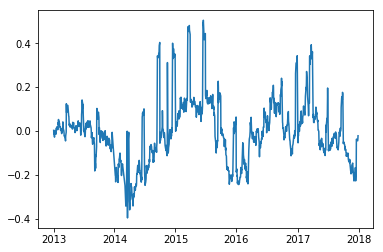

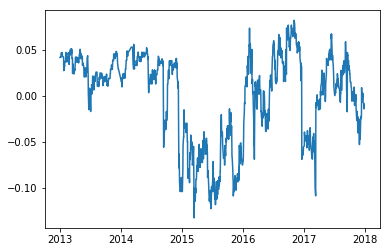

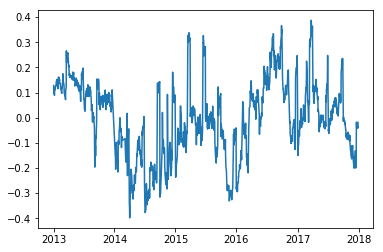

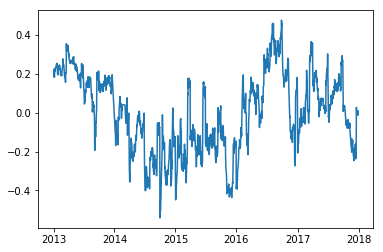

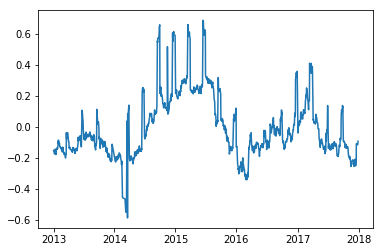

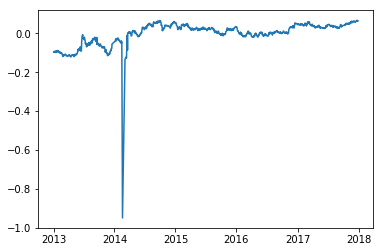

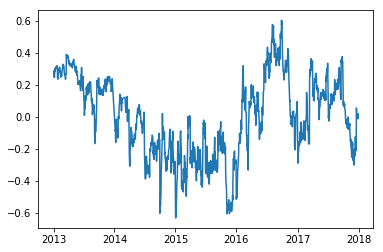

In [80]:
# Plot residuals
for i in range(len(pair_screen)):
    plt.plot(pair_screen.iloc[i,-1])
    plt.show()

# Trading Rules Optimazition

In [81]:
Cap = 1000000
Cap_Alloc = [Cap*pair_screen.iloc[i,2]/sum(pair_screen['Vol']) for i in range(len(pair_screen))]

In [94]:
# This dataframe store trading performance for different open/close/cut ratio
is_summary_all = pd.DataFrame(columns = ['Open_ratio', 'Close_ratio', 'Cut_ratio', 'Pnl', 'Freq', 'Hit ratio','Return rate', "Details"])

number = 0

for open_ratio in [1, 1.5, 2]:
    for close_ratio in [0, 0.2, 0.5]:
        for cut_ratio in [3, 3.5, 4]:

            number += 1
            
            # Each is_summary dataframe store trading performance for a pair for given open/close/cut ratio
            is_summary = pd.DataFrame(columns=['Pnl','Freq','Hit ratio','return rate','Trade time'])

            for i in range(len(pair_screen.index)):
                residuals = pair_screen.iloc[i,-1]
                vol = pair_screen.iloc[i,2]
                cap = Cap*pair_screen.iloc[i,2]/sum(pair_screen['Vol'])
                Pnl = 0
                Freq = 0
                Hit_Freq = 0
                Trade_Time = []
                open_flag = 0
                open_price = 0
                for date in range(len(residuals)):

                    # Open a position
                    if open_flag == 0 and abs(residuals[date]) > open_ratio * vol:
                        open_flag = 1
                        open_price = residuals[date]
                        Trade_Time.append(residuals.index[date])
                        Freq += 1
                        tran = 14 + 0.00221*cap/abs(open_price + pair_screen.iloc[i,4])*(1+abs(beta)) # Transaction cost = fixed cost + 0.00221/per share
                        Pnl -= tran

                    # Close a position
                    elif open_flag == 1 and ( abs(residuals[date]) < close_ratio * vol or residuals[date] * open_price < 0):
                        open_flag = 0
                        close_price = residuals[date]
                        Pnl += abs((open_price - close_price)/(open_price + pair_screen.iloc[i,4]))*cap
                        Trade_Time.append(residuals.index[date])
                        Hit_Freq += 1
                        Pnl -= tran

                    # Cut a position
                    elif open_flag == 1 and abs(residuals[date]) > cut_ratio * vol:
                        open_flag = 0
                        cut_price = residuals[date]
                        Pnl += -abs((open_price - cut_price)/(open_price +pair_screen.iloc[i,4]))*cap
                        Trade_Time.append(residuals.index[date])   
                        Pnl -= tran

                # Close all position in the end 
                if open_flag == 1:
                    open_flag = 0
                    cut_price = residuals[date]
                    Pnl += -abs((open_price - cut_price)/(open_price+pair_screen.iloc[i,4]))*cap
                    Trade_Time.append(residuals.index[date]) 
                    Pnl -= tran

                return_rate = Pnl/cap/(2017-2013+1)
                is_summary.loc[pair_screen.index[i]] = [Pnl, Freq, Hit_Freq/Freq, return_rate, Trade_Time]   

            # Calculate portfolio performance
            TotalPnl = is_summary['Pnl'].sum()
            Freq = is_summary['Freq'].sum()
            Hit_ratio = sum([is_summary.iloc[i,1]*is_summary.iloc[i,2] for i in range(len(is_summary))])/Freq
            return_rate = TotalPnl/Cap/(2017-2013+1)
            is_summary.loc['Total'] = [TotalPnl, Freq, Hit_ratio, return_rate, 'N/A']
            
            is_summary_all.loc[str(number)] = [open_ratio, close_ratio, cut_ratio, TotalPnl, Freq, Hit_ratio, return_rate, is_summary]

In [95]:
is_summary_all.sort_values(by = 'Pnl', ).iloc[:,:-1]

,Open_ratio,Close_ratio,Cut_ratio,Pnl,Freq,Hit ratio,Return rate
19,2,0,3,21634.639934,48,0.583333,0.004327
22,2,0.2,3,22602.606394,51,0.607843,0.004521
21,2,0,4,27566.858654,31,0.967742,0.005513
20,2,0,3.5,27566.858654,31,0.967742,0.005513
24,2,0.2,4,28320.330095,34,0.970588,0.005664
23,2,0.2,3.5,28320.330095,34,0.970588,0.005664
10,1.5,0,3,35305.443596,70,0.700000,0.007061
11,1.5,0,3.5,40062.068777,52,0.961538,0.008012
12,1.5,0,4,40062.068777,52,0.961538,0.008012
13,1.5,0.2,3,42219.682592,79,0.746835,0.008444


After reading the table above, I decide to use number 8 rule, which is open_ratio 1, close ratio 0.5, cut ratio 3.5.

In [96]:
def hit_map(residuals, trade_time, open_ratio , close_ratio, cut_ratio, vol, mean, title):
    
    # This function draws hit_map for given pairs.
    # Trade_time is list of trade time
    plt.figure(figsize = (20,10))
    plt.title(title, fontsize = 'xx-large')
    plt.plot(residuals + mean)
    plt.scatter(trade_time,residuals[trade_time]+mean, c = 'r', s = 50)
    plt.plot([residuals.index[0],residuals.index[-1]], [open_ratio*vol+mean, open_ratio*vol+mean], color = 'green')
    plt.plot([residuals.index[0],residuals.index[-1]], [-open_ratio*vol+mean, -open_ratio*vol+mean], color = 'green')
    plt.plot([residuals.index[0],residuals.index[-1]], [close_ratio*vol+mean, close_ratio*vol+mean], color = 'orange')
    plt.plot([residuals.index[0],residuals.index[-1]], [-close_ratio*vol+mean, -close_ratio*vol+mean], color = 'orange')
    plt.plot([residuals.index[0],residuals.index[-1]], [cut_ratio*vol+mean, cut_ratio*vol+mean], color = 'black')
    plt.plot([residuals.index[0],residuals.index[-1]], [-cut_ratio*vol+mean, -cut_ratio*vol+mean], color = 'black')   
    plt.show()

                      Pnl Freq  Hit ratio  return rate
(ED4,TU1)    11675.629742   18   1.000000     0.017008
(ED1,ED2)     3769.920400   11   1.000000     0.016752
(ED3,TU1)    14471.962856   23   1.000000     0.019874
(ED2,TU1)    15171.882287   19   1.000000     0.015937
(ED5,TU1)     9908.164243   10   0.900000     0.010347
(ED18,ED19)  -7553.328638    6   0.666667    -0.028623
(ED1,TU1)    12522.205843   15   1.000000     0.010551
Total        59966.436733  102   0.970588     0.011993


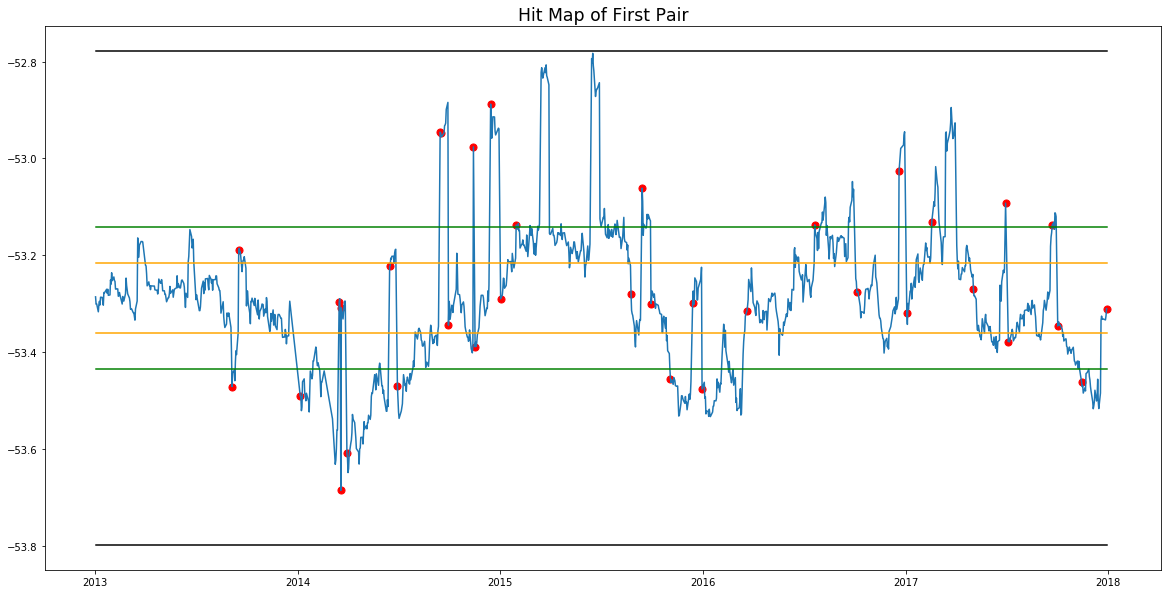

In [97]:
# Plot Hit map for first pair in sample trading
open_ratio = 1
close_ratio = 0.5
cut_ratio = 3.5
is_summary = is_summary_all.loc['5','Details']
print(is_summary.iloc[:,:-1])
name = 'Hit Map of First Pair'
hit_map(pair_screen.iloc[0,-1], is_summary.iloc[0,-1],open_ratio,close_ratio,cut_ratio,pair_screen.iloc[0,2],pair_screen.iloc[0,4],name)

# Out of Sample Test 

In [99]:
open_ratio = 1
close_ratio = 0.5
cut_ratio = 3.5

oos_summary = pd.DataFrame(columns=['Pnl','Freq','Hit ratio', 'Return rate','Trade time','Residuals'])
for i in range(len(pair_screen)):
    
    # out of sample residuals
    ticker1, ticker2 = pair_screen.index[i].lstrip('(').rstrip(')').split(',')
    residuals = df_test[ticker2] - pair_screen.iloc[i,3] * df_test[ticker1] - pair_screen.iloc[i,4]
    
    # Trade test
    vol = pair_screen.iloc[i,2]
    cap = Cap*pair_screen.iloc[i,2]/sum(pair_screen['Vol'])
    Pnl = 0
    Freq = 0
    Hit_Freq = 0
    Trade_Time = []
    open_flag = 0
    open_price = 0
    for date in range(len(residuals)):
        
        # Open a position
        if open_flag == 0 and abs(residuals[date]) > open_ratio * vol:
            open_flag = 1
            open_price = residuals[date]
            Trade_Time.append(residuals.index[date])
            Freq += 1
            tran = 14 + 0.00221*cap/abs(open_price + pair_screen.iloc[i,4])*(1+abs(beta)) # Transaction cost = fixed cost + 0.00221/per share
            Pnl -= tran
        
        # Close a position
        elif open_flag == 1 and ( abs(residuals[date]) < close_ratio * vol or residuals[date] * open_price < 0):
            open_flag = 0
            close_price = residuals[date]
            Pnl += abs((open_price - close_price)/(open_price + pair_screen.iloc[i,4]))*cap
            Trade_Time.append(residuals.index[date])
            Hit_Freq += 1
            Pnl -= tran
            
        # Cut a position
        elif open_flag == 1 and abs(residuals[date]) > cut_ratio * vol:
            open_flag = 0
            cut_price = residuals[date]
            Pnl += -abs((open_price - cut_price)/(open_price +pair_screen.iloc[i,4]))*cap
            Trade_Time.append(residuals.index[date]) 
            Pnl -= tran
    
    # Close all position in the end 
    if open_flag == 1:
        open_flag = 0
        cut_price = residuals[date]
        Pnl += -abs((open_price - cut_price)/(open_price +pair_screen.iloc[i,4]))*cap
        Trade_Time.append(residuals.index[date]) 
        Pnl -= tran
    
    return_rate = Pnl/cap/(10/12)
    oos_summary.loc[pair_screen.index[i]] = [Pnl, Freq, Hit_Freq/Freq if Freq!=0 else 0,return_rate, Trade_Time, residuals]   

# Calculate portfolio performance
TotalPnl = oos_summary['Pnl'].sum()
Freq = oos_summary['Freq'].sum()
Hit_ratio = sum([oos_summary.iloc[i,1]*oos_summary.iloc[i,2] for i in range(len(oos_summary))])/Freq
return_rate = TotalPnl/Cap/(10/12)
oos_summary.loc['Total'] = [TotalPnl, Freq, Hit_ratio, return_rate, 'N/A', 'N/A']

                     Pnl Freq  Hit ratio  Return rate
(ED4,TU1)     693.252806    3   0.666667     0.006059
(ED1,ED2)     979.867869    4   1.000000     0.026124
(ED3,TU1)     605.055254    3   0.666667     0.004985
(ED2,TU1)     826.602473    4   0.750000     0.005210
(ED5,TU1)    1334.623326    3   0.666667     0.008363
(ED18,ED19)  -587.317151    1   0.000000    -0.013354
(ED1,TU1)    3065.003421    5   0.800000     0.015495
Total        6917.087998   23   0.739130     0.008301


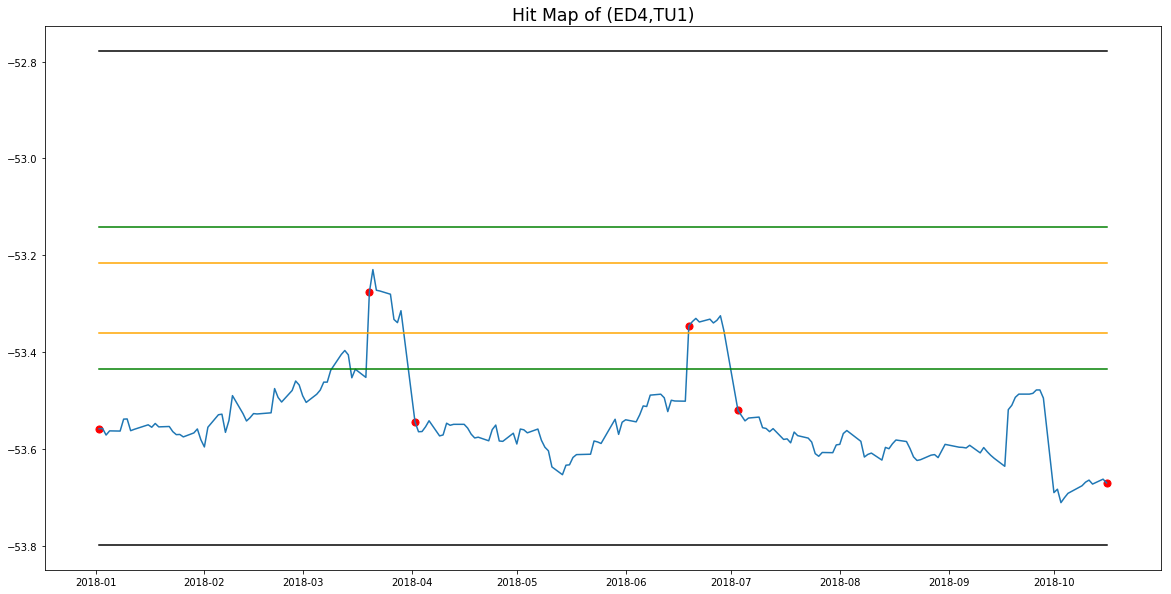

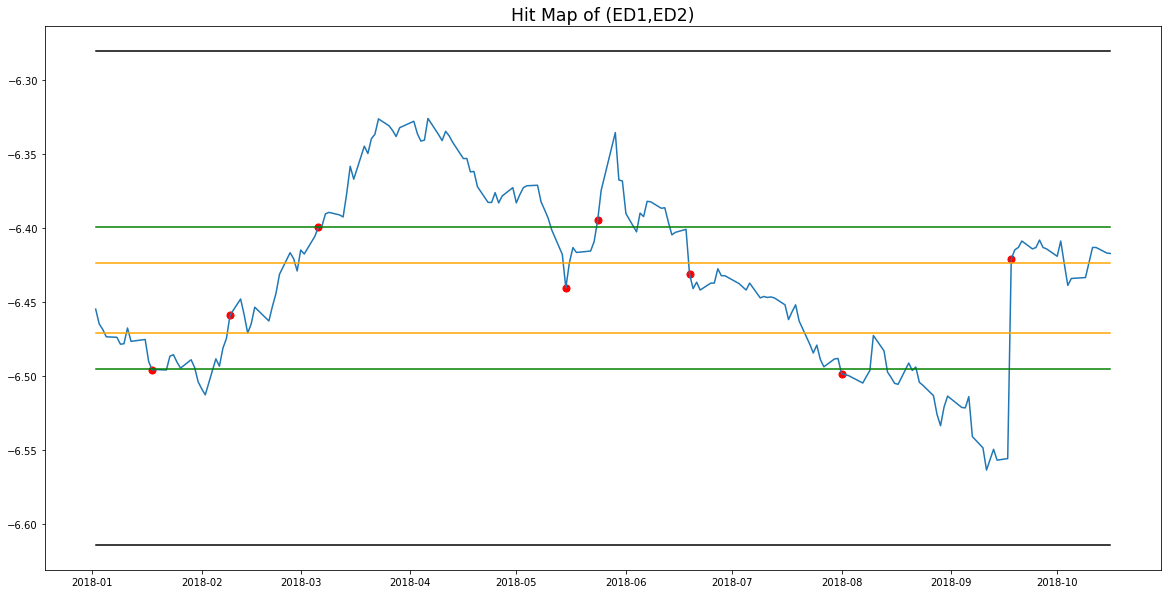

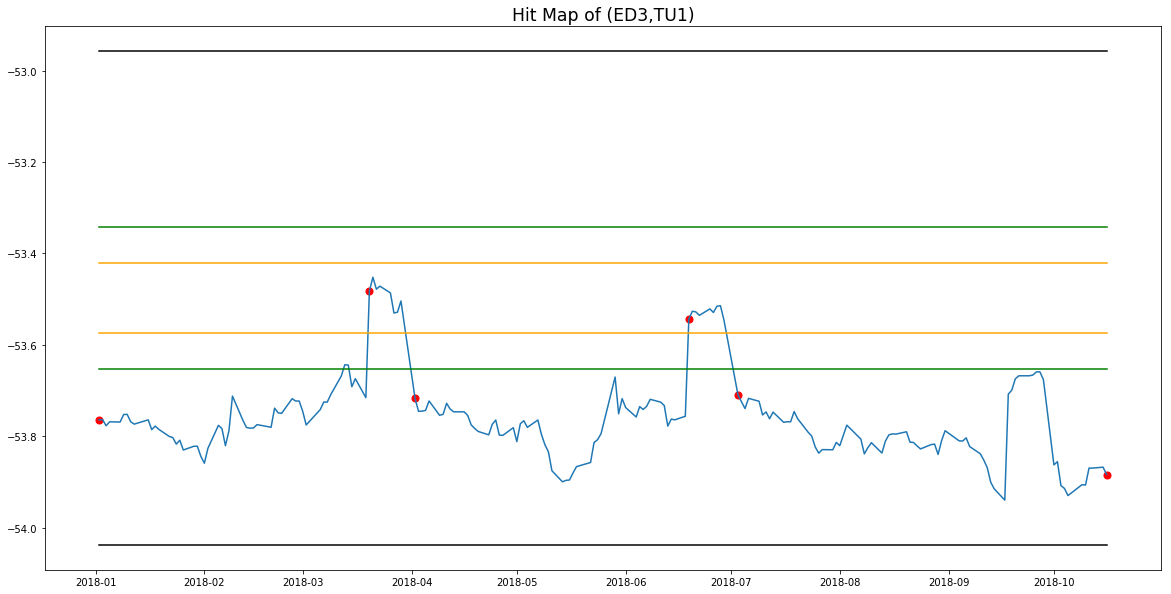

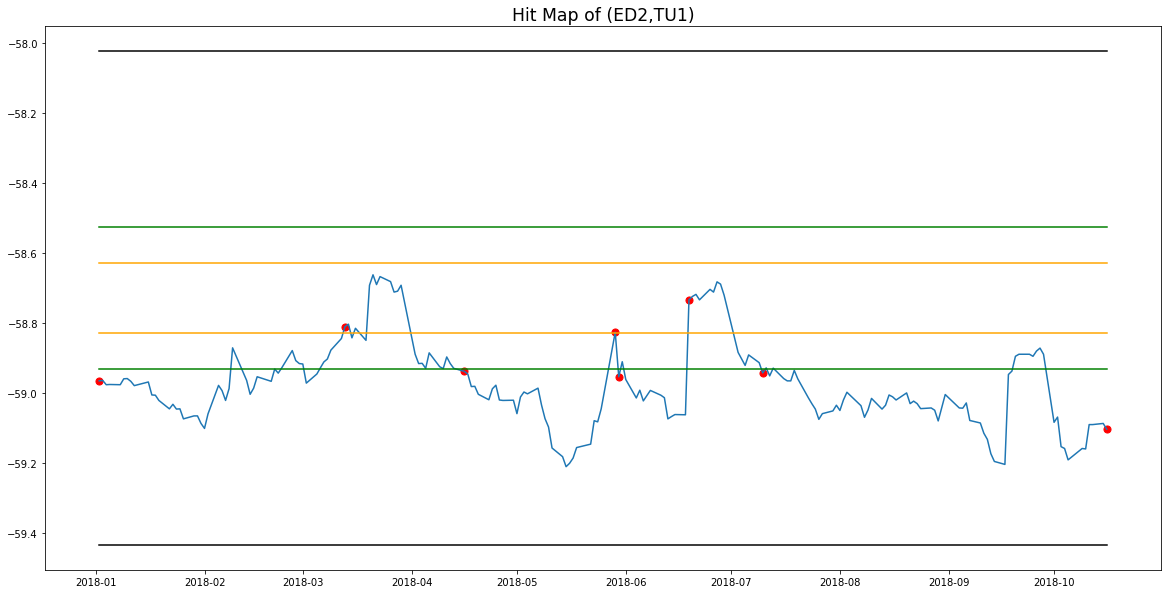

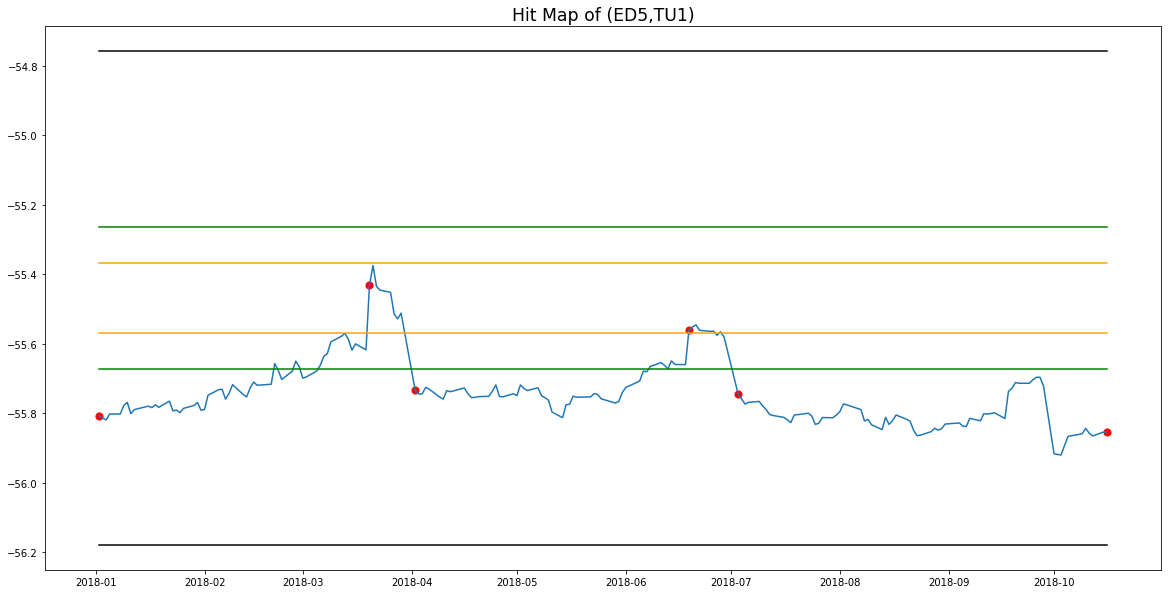

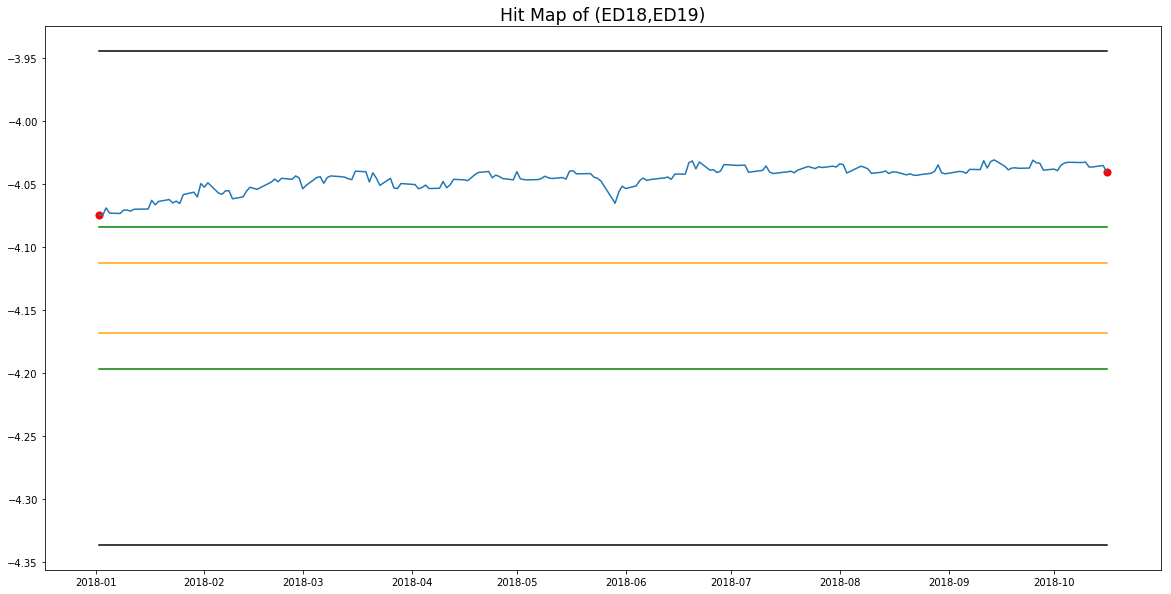

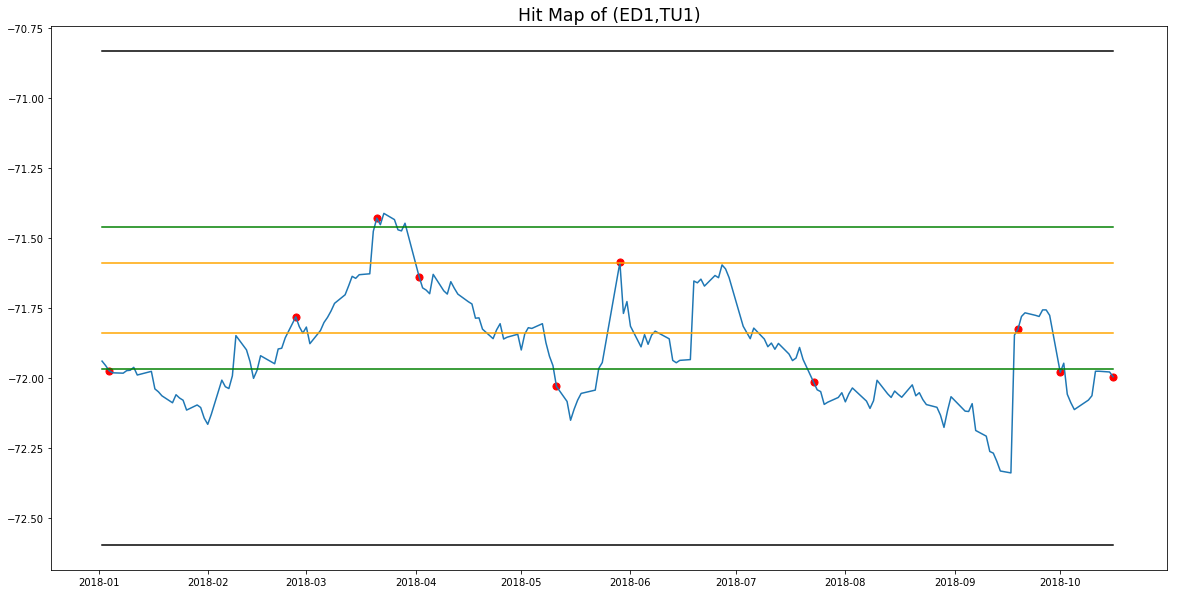

In [100]:
# Out of Sample Summaries
print(oos_summary.iloc[:,:-2])

# Hit map for each pair
for i in range(len(pair_screen)):
    name = 'Hit Map of ' + pair_screen.index[i]
    hit_map(oos_summary.iloc[i,-1], oos_summary.iloc[i,-2], open_ratio , close_ratio, cut_ratio, pair_screen.iloc[i,2],pair_screen.iloc[i,4], name)
    